## Introduction and Objective

The core objective of this analysis is to evaluate the effectiveness of personalized coupon campaigns in driving higher redemption rates compared to non-personalized campaigns. We hypothesize that personalized coupons, which are tailored to the individual preferences and behaviors of customers, lead to higher redemption rates than standard, non-personalized coupons.

This hypothesis will be tested using data from four distinct datasets, each offering a unique perspective on the customers, their demographics, the coupons issued, and their redemption patterns.

### Datasets Overview

1. **Campaign Table (`campaign_table.csv`)**:
   - **Purpose**: Contains information on the type of coupon campaign and the households targeted.
   - **Fields**: `DESCRIPTION` (type of campaign), `household_key` (unique identifier for each household), `CAMPAIGN` (campaign identifier).
   - **Shape**: 7208 rows × 3 columns.

2. **Household Demographics (`hh_demographic.csv`)**:
   - **Purpose**: Provides demographic information about the households, such as age, marital status, income, and homeownership.
   - **Fields**: `AGE_DESC`, `MARITAL_STATUS_CODE`, `INCOME_DESC`, `HOMEOWNER_DESC`, `HH_COMP_DESC` (household composition), `HOUSEHOLD_SIZE_DESC`, `KID_CATEGORY_DESC`, `household_key`.
   - **Shape**: 801 rows × 8 columns.

3. **Coupons Issued (`coupon.csv`)**:
   - **Purpose**: Lists the coupons that were issued as part of various campaigns.
   - **Fields**: `COUPON_UPC` (coupon code), `PRODUCT_ID`, `CAMPAIGN`.
   - **Shape**: 124548 rows × 3 columns.

4. **Coupon Redemption (`coupon_redempt.csv`)**:
   - **Purpose**: Tracks which of the issued coupons were actually redeemed.
   - **Fields**: `household_key`, `DAY` (the day the coupon was redeemed), `COUPON_UPC`, `CAMPAIGN`.
   - **Shape**: 2318 rows × 4 columns.

In the following sections, we will delve into a comprehensive analysis, merging these datasets to create a unified view of the coupon campaign's impact on customer behavior. We will utilize statistical methods to validate our hypothesis and derive actionable insights that can shape future marketing strategies.


In [11]:
import pandas as pd

coupon_hh = pd.read_csv("/mnt/c/Users/Aluminum/Documents/DS Projects 23'/Kaggle/AB_testing/full_data/campaign_table.csv");coupon_hh.head(), coupon_hh.shape

(  DESCRIPTION  household_key  CAMPAIGN
 0       TypeA             17        26
 1       TypeA             27        26
 2       TypeA            212        26
 3       TypeA            208        26
 4       TypeA            192        26,
 (7208, 3))

In [12]:
hh_demo = pd.read_csv("/mnt/c/Users/Aluminum/Documents/DS Projects 23'/Kaggle/AB_testing/full_data/hh_demographic.csv"); hh_demo.head(), hh_demo.shape

(  AGE_DESC MARITAL_STATUS_CODE INCOME_DESC HOMEOWNER_DESC      HH_COMP_DESC  \
 0      65+                   A      35-49K      Homeowner  2 Adults No Kids   
 1    45-54                   A      50-74K      Homeowner  2 Adults No Kids   
 2    25-34                   U      25-34K        Unknown     2 Adults Kids   
 3    25-34                   U      75-99K      Homeowner     2 Adults Kids   
 4    45-54                   B      50-74K      Homeowner     Single Female   
 
   HOUSEHOLD_SIZE_DESC KID_CATEGORY_DESC  household_key  
 0                   2      None/Unknown              1  
 1                   2      None/Unknown              7  
 2                   3                 1              8  
 3                   4                 2             13  
 4                   1      None/Unknown             16  ,
 (801, 8))

In [13]:
coupons = pd.read_csv("/mnt/c/Users/Aluminum/Documents/DS Projects 23'/Kaggle/AB_testing/full_data/coupon.csv"); coupons.head(), coupons.shape

(    COUPON_UPC  PRODUCT_ID  CAMPAIGN
 0  10000089061       27160         4
 1  10000089064       27754         9
 2  10000089073       28897        12
 3  51800009050       28919        28
 4  52100000076       28929        25,
 (124548, 3))

In [14]:
coupon_redempt = pd.read_csv("/mnt/c/Users/Aluminum/Documents/DS Projects 23'/Kaggle/AB_testing/full_data/coupon_redempt.csv"); coupon_redempt.head(), coupon_redempt.shape

(   household_key  DAY   COUPON_UPC  CAMPAIGN
 0              1  421  10000085364         8
 1              1  421  51700010076         8
 2              1  427  54200000033         8
 3              1  597  10000085476        18
 4              1  597  54200029176        18,
 (2318, 4))

In [20]:
import pandas as pd

def calculate_redemption_rates(coupon_hh, coupon_redempt, coupons, hh_demo):
    # Type A calculations
    type_a_households = coupon_hh[coupon_hh['DESCRIPTION'] == 'TypeA'][['household_key', 'CAMPAIGN']].drop_duplicates()
    type_a_redemptions = coupon_redempt[coupon_redempt['CAMPAIGN'].isin(type_a_households['CAMPAIGN'])]
    type_a_redemptions_agg = type_a_redemptions.groupby('household_key').size().reset_index(name='redemptions')
    type_a_redemptions_merged = type_a_households.merge(type_a_redemptions_agg, on='household_key', how='left')
    type_a_redemptions_merged['redemptions'].fillna(0, inplace=True)
    type_a_redemptions_merged['coupons_sent_type_a'] = 16
    type_a_redemptions_merged['redemption_rate_type_a'] = type_a_redemptions_merged['redemptions'] / type_a_redemptions_merged['coupons_sent_type_a']
    
    # Type B and C calculations
    type_bc_campaigns = coupon_hh[coupon_hh['DESCRIPTION'].isin(['TypeB', 'TypeC'])][['household_key', 'CAMPAIGN']].drop_duplicates()
    coupons_sent_per_campaign = coupons.groupby('CAMPAIGN')['COUPON_UPC'].nunique().reset_index(name='unique_coupons_sent')
    type_bc_households_with_coupons = type_bc_campaigns.merge(coupons_sent_per_campaign, on='CAMPAIGN', how='left')
    redemptions_agg = coupon_redempt.groupby(['household_key', 'CAMPAIGN'])['COUPON_UPC'].count().reset_index(name='redemptions')
    type_bc_redemption_rate = type_bc_households_with_coupons.merge(redemptions_agg, on=['household_key', 'CAMPAIGN'], how='left')
    type_bc_redemption_rate['redemptions'].fillna(0, inplace=True)
    type_bc_redemption_rate['redemption_rate_type_bc'] = type_bc_redemption_rate['redemptions'] / type_bc_redemption_rate['unique_coupons_sent']
    
    # Merge demographic data
    merged_data = pd.merge(coupon_hh, hh_demo, on="household_key", how="inner")
    
    # Merge redemption rates
    merged_data = pd.merge(merged_data, type_a_redemptions_merged[['household_key', 'redemption_rate_type_a', 'coupons_sent_type_a']], on='household_key', how='left')
    merged_data = pd.merge(merged_data, type_bc_redemption_rate[['household_key', 'redemption_rate_type_bc', 'unique_coupons_sent']], on='household_key', how='left', suffixes=('', '_type_bc'))

    # dropping duplicate rows
    merged_data.drop_duplicates(inplace=True)
    
    return merged_data

In [21]:
merged_df = calculate_redemption_rates(coupon_hh, coupon_redempt, coupons, hh_demo); merged_df.head(), merged_df.shape

(   DESCRIPTION  household_key  CAMPAIGN AGE_DESC MARITAL_STATUS_CODE  \
 0        TypeA             17        26      65+                   B   
 5        TypeA             17        30      65+                   B   
 10       TypeA             17         8      65+                   B   
 15       TypeA             17        13      65+                   B   
 20       TypeA             17        18      65+                   B   
 
    INCOME_DESC HOMEOWNER_DESC      HH_COMP_DESC HOUSEHOLD_SIZE_DESC  \
 0    Under 15K      Homeowner  2 Adults No Kids                   2   
 5    Under 15K      Homeowner  2 Adults No Kids                   2   
 10   Under 15K      Homeowner  2 Adults No Kids                   2   
 15   Under 15K      Homeowner  2 Adults No Kids                   2   
 20   Under 15K      Homeowner  2 Adults No Kids                   2   
 
    KID_CATEGORY_DESC  redemption_rate_type_a  coupons_sent_type_a  \
 0       None/Unknown                     0.0           

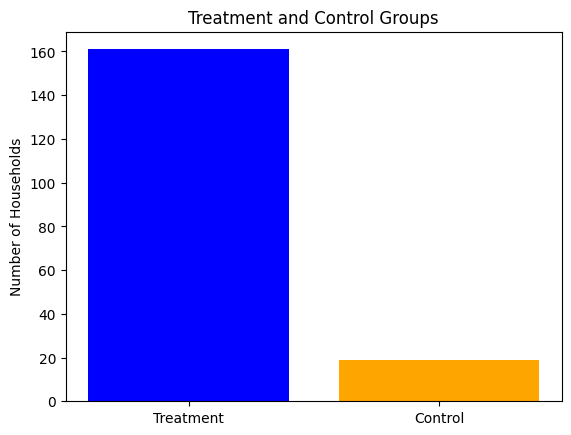

(     DESCRIPTION  household_key  CAMPAIGN AGE_DESC MARITAL_STATUS_CODE  \
 0          TypeA             17        26      65+                   B   
 1205       TypeA           2420        26    45-54                   U   
 6728       TypeA           2182        26    45-54                   A   
 6744       TypeA           2069        26    35-44                   U   
 6753       TypeA           2063        26    55-64                   A   
 
      INCOME_DESC HOMEOWNER_DESC      HH_COMP_DESC HOUSEHOLD_SIZE_DESC  \
 0      Under 15K      Homeowner  2 Adults No Kids                   2   
 1205      15-24K        Unknown     2 Adults Kids                   3   
 6728      75-99K      Homeowner  2 Adults No Kids                   2   
 6744      15-24K        Unknown     Single Female                   1   
 6753      75-99K      Homeowner  2 Adults No Kids                   2   
 
      KID_CATEGORY_DESC  redemption_rate_type_a  coupons_sent_type_a  \
 0         None/Unknown       

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def create_treatment_control_groups(merged_df):
    # Group by household and get unique descriptions for each household
    campaign_types_per_hh = merged_df.groupby('household_key')['DESCRIPTION'].unique()
    
    # Identify households that only received TypeA (treatment) and those that received only TypeB or TypeC (control)
    treatment_hh = campaign_types_per_hh[campaign_types_per_hh.apply(lambda x: set(x) == {'TypeA'})].index
    control_hh = campaign_types_per_hh[campaign_types_per_hh.apply(lambda x: ('TypeA' not in x) and ('TypeB' in x or 'TypeC' in x))].index
    
    # Apply the masks to merged_df to create treatment and control groups
    treatment_group = merged_df[merged_df['household_key'].isin(treatment_hh)]
    control_group = merged_df[merged_df['household_key'].isin(control_hh)]

    # Drop specified columns from control and treatment groups
    treatment_group = treatment_group.drop(columns=['redemption_rate_type_bc', 'unique_coupons_sent'])
    control_group = control_group.drop(columns=['redemption_rate_type_a', 'coupons_sent_type_a'])

    # Dropping duplicate rows based on 'household_key'
    treatment_group = treatment_group.drop_duplicates(subset='household_key')
    control_group = control_group.drop_duplicates(subset='household_key')

    treatment_group['treatment_flag'] = 1
    control_group['treatment_flag'] = 0
    combined_df = pd.concat([treatment_group, control_group], sort=False)

    fig, ax = plt.subplots()
    ax.bar(['Treatment', 'Control'], [len(treatment_group), len(control_group)], color=['blue', 'orange'])
    ax.set_ylabel('Number of Households')
    ax.set_title('Treatment and Control Groups')
    plt.show()
    
    return combined_df, treatment_group, control_group

df,treatment_group, control_group = create_treatment_control_groups(merged_df)

df.head(), df.shape

In [51]:
df

,DESCRIPTION,household_key,CAMPAIGN,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,redemption_rate_type_a,coupons_sent_type_a,treatment_flag,redemption_rate_type_bc,unique_coupons_sent
0,TypeA,17,26,65+,B,Under 15K,Homeowner,2 Adults No Kids,2,None/Unknown,0.0000,16.0,1,NaN,NaN
1205,TypeA,2420,26,45-54,U,15-24K,Unknown,2 Adults Kids,3,1,0.0625,16.0,1,NaN,NaN
6728,TypeA,2182,26,45-54,A,75-99K,Homeowner,2 Adults No Kids,2,None/Unknown,0.0000,16.0,1,NaN,NaN
6744,TypeA,2069,26,35-44,U,15-24K,Unknown,Single Female,1,None/Unknown,0.0000,16.0,1,NaN,NaN
6753,TypeA,2063,26,55-64,A,75-99K,Homeowner,2 Adults No Kids,2,None/Unknown,0.0000,16.0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57482,TypeB,31,23,35-44,B,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,NaN,NaN,0,0.111111,18.0
57486,TypeB,831,24,45-54,B,50-74K,Homeowner,1 Adult Kids,3,2,NaN,NaN,0,0.000000,2.0
57487,TypeB,2252,24,45-54,A,50-74K,Homeowner,2 Adults Kids,4,2,NaN,NaN,0,0.000000,2.0
57488,TypeB,1815,24,45-54,U,25-34K,Unknown,2 Adults No Kids,2,None/Unknown,NaN,NaN,0,0.000000,2.0


In [48]:
from causalml.match import NearestNeighborMatch
from sklearn.linear_model import LogisticRegression

# Select covariates for matching
covariates = ['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC']

# Convert categorical variables to dummies
df_with_dummies = pd.get_dummies(df[covariates + ['treatment_flag']], drop_first=True)

# Define the treatment flag and covariates
treatment_col = 'treatment_flag'
covariate_cols = df_with_dummies.columns.drop(treatment_col)

# Perform nearest neighbor matching
nn_match = NearestNeighborMatch(replace=False, ratio=1, random_state=42)
propensity_model = LogisticRegression()
propensity_model.fit(df_with_dummies[covariate_cols], df_with_dummies[treatment_col])

# Predict the propensity score
df_with_dummies['propensity_score'] = propensity_model.predict_proba(df_with_dummies[covariate_cols])[:, 1]

# Now, use the propensity scores for matching
matched_df = nn_match.match(
    data=df_with_dummies,
    treatment_col=treatment_col,
    score_cols=['propensity_score']
)


# Inspect the matched dataset
matched_df.head()

/home/parkermoe/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/parkermoe/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


,treatment_flag,AGE_DESC_25-34,AGE_DESC_35-44,AGE_DESC_45-54,AGE_DESC_55-64,AGE_DESC_65+,MARITAL_STATUS_CODE_B,MARITAL_STATUS_CODE_U,INCOME_DESC_125-149K,INCOME_DESC_15-24K,...,HH_COMP_DESC_Single Male,HH_COMP_DESC_Unknown,HOUSEHOLD_SIZE_DESC_2,HOUSEHOLD_SIZE_DESC_3,HOUSEHOLD_SIZE_DESC_4,HOUSEHOLD_SIZE_DESC_5+,KID_CATEGORY_DESC_2,KID_CATEGORY_DESC_3+,KID_CATEGORY_DESC_None/Unknown,propensity_score
53480,1,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,0.930413
54225,1,False,False,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,0.741435
57167,1,False,False,False,False,True,False,True,False,False,...,False,False,True,False,False,False,False,False,True,0.903245
50370,1,False,False,True,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,0.888294
35303,1,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,0.930413


In [52]:
filtered_df = df.loc[matched_df.index]

In [54]:
filtered_df.head(), filtered_df.shape

(      DESCRIPTION  household_key  CAMPAIGN AGE_DESC MARITAL_STATUS_CODE  \
 53480       TypeA            387         8    25-34                   B   
 54225       TypeA            302         8    45-54                   U   
 57167       TypeA            370        18      65+                   U   
 50370       TypeA            680         8    45-54                   U   
 35303       TypeA           2130         8    25-34                   B   
 
       INCOME_DESC HOMEOWNER_DESC      HH_COMP_DESC HOUSEHOLD_SIZE_DESC  \
 53480      50-74K      Homeowner     Single Female                   1   
 54225      35-49K      Homeowner     2 Adults Kids                   3   
 57167      50-74K        Unknown  2 Adults No Kids                   2   
 50370      50-74K      Homeowner           Unknown                   1   
 35303      50-74K      Homeowner     Single Female                   1   
 
       KID_CATEGORY_DESC  redemption_rate_type_a  coupons_sent_type_a  \
 53480      None/

In [55]:
# Ensure the dataset has the necessary columns
analysis_df = filtered_df[['treatment_flag', 'redemption_rate_type_a', 'redemption_rate_type_bc']]


In [59]:
analysis_df

,treatment_flag,redemption_rate_type_a,redemption_rate_type_bc
53480,1,0.0625,NaN
54225,1,0.0000,NaN
57167,1,0.0000,NaN
50370,1,0.1250,NaN
35303,1,0.9375,NaN
57266,1,0.0000,NaN
38528,1,0.0000,NaN
56924,1,0.1875,NaN
57287,1,0.0000,NaN
53261,1,0.0000,NaN


In [57]:
# Assuming 'analysis_df' contains the matched data with the 'treatment_flag' and 'redemption_rate_type_a'
average_outcome_type_a = analysis_df[analysis_df['treatment_flag'] == 1]['redemption_rate_type_a'].mean()
print(f'Average outcome for Type A with treatment: {average_outcome_type_a}')


Average outcome for Type A with treatment: 0.08333333333333333


In [58]:
# Assuming 'analysis_df' contains the matched data with the 'treatment_flag' and 'redemption_rate_type_bc'
average_outcome_type_bc = analysis_df[analysis_df['treatment_flag'] == 0]['redemption_rate_type_bc'].mean()
print(f'Average outcome for Type B and C without treatment: {average_outcome_type_bc}')


Average outcome for Type B and C without treatment: 0.014550264550264548


In [62]:
import numpy as np
import pandas as pd
from scipy import stats

# Assuming 'analysis_df' is your DataFrame
# Separate the two groups, dropping NaN values for each group
personalized_rates = analysis_df[analysis_df['treatment_flag'] == 1]['redemption_rate_type_a'].dropna()
non_personalized_rates = analysis_df[analysis_df['treatment_flag'] == 0]['redemption_rate_type_bc'].dropna()

# Check for normality
# If p-value > 0.05 for both, data follows a normal distribution
print(stats.shapiro(personalized_rates))
print(stats.shapiro(non_personalized_rates))

# If both are normal, use t-test
# If not, use Mann-Whitney U test
if stats.shapiro(personalized_rates)[1] > 0.05 and stats.shapiro(non_personalized_rates)[1] > 0.05:
    t_stat, p_value = stats.ttest_ind(personalized_rates, non_personalized_rates, equal_var=False)
    print("Using t-test")
else:
    u_stat, p_value = stats.mannwhitneyu(personalized_rates, non_personalized_rates, alternative='two-sided')
    print("Using Mann-Whitney U test")

# Check the p-value to determine the significance
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in redemption rates.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in redemption rates.")

# Print the results
print(f"Statistic: {t_stat if 't_stat' in locals() else u_stat}, p-value: {p_value}")



ShapiroResult(statistic=0.42958658933639526, pvalue=2.0781106968570384e-07)
ShapiroResult(statistic=0.4779896140098572, pvalue=5.193282959226053e-07)
Using Mann-Whitney U test
Fail to reject the null hypothesis: There is no significant difference in redemption rates.
Statistic: 185.5, p-value: 0.3173431779128052
